# Model sensitivity to parameters

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize as scopt
import scipy.stats as stats
import scipy.integrate as scint
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
## Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import seaborn as sns

import pyabc
import tempfile
import os

# Custom imports
import pyEnceladus.universal_htv as uhtv
import pyEnceladus.data_htv as dhtv
import pyEnceladus.physical as phc
import pyEnceladus.plot_tools as cplt
import pyEnceladus.stats_analysis as homestats
from pyEnceladus.biosims import makePriors, makeOnePrior
from pyEnceladus.plot_abc import confusion_format
import pyEnceladus.simulation_qstar as smqs

palette = sns.color_palette('colorblind')

mpl.rc('axes', labelsize=7)
mpl.rc('legend', fontsize=7)
mpl.rc('xtick', labelsize=5.5)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=5.5)
mpl.rc('text',usetex=False)

labelsDict = {'FH2':r'$\Phi_{\mathregular{H_2}}$','FCO2':r'$\Phi_{\mathregular{CO_2}}$','FCH4':r'$\Phi_{\mathregular{CH_4}}$',
              'R1':r'$\mathregular{H_2}:\mathregular{CH_4}$','R2':r'$R_2$'}


In [2]:
observations    = pd.read_csv('data/observations/observations.csv',delimiter=';',index_col=0)
logobservations = pd.read_csv('data/observations/logobservations.csv',delimiter=';',index_col=0)
observation     = np.load('data/observations/observation.npy',allow_pickle=True)

In this part, we fix $T_f$ and the compositions of both ocean and at values reflecting habitability and uninhabitability.

In [3]:
oconc_hab = {'H2':10**(-1),'CO2':10**(-6),'CH4':10**(-6)}
fconc_hab = {'H2':10**(-7),'CO2':10**(-2),'CH4':10**(-8)}
Tf_hab    = 400

In [4]:
F      = stats.uniform(1e9, 9e9)
dth    = stats.uniform(-8, 7)
dgacat = stats.uniform(50000, 25000)
dhaeq  = stats.uniform(85000, 320000)
T_eq   = stats.uniform(273+40, 50)
tau    = stats.uniform(1e-6,100e-6)
# pyabc is useful to sample n-dimensional distributions but unfortunately does not manage seed (afaIk)
param_space = pyabc.Distribution(F=F,dth=dth,dgacat=dgacat,dhaeq=dhaeq,T_eq=T_eq,tau=tau)
prior = pyabc.Distribution(H2f=pyabc.RV("uniform", -8, 7),H2o=pyabc.RV("uniform", -8, 2),
                           CO2f=pyabc.RV("uniform", -8, 2),CO2o=pyabc.RV("uniform", -2.39, 1.39),
                           CH4f=pyabc.RV("uniform", -8, 4),CH4o=pyabc.RV("uniform", -8, 2),
                           Tf = pyabc.RV("uniform", 300,320))
param_default = {'F':5e9,'dth':np.log10(0.03),'dgacat':dhtv.methanogens['dgacat'],
                 'dhaeq':dhtv.methanogens['dhaeq'],'T_eq':dhtv.methanogens['T_eq'],'tau':1.73e-5}

In [5]:
def model(param,oconc,fconc,Tf):
    inhabited_plume,uninhabited_plume,totalconvF,bmasstot,success = smqs.sim_meth_enc(F=param['F'],Tf=Tf,To=275,
                                                                                      oconc=oconc,fconc=fconc,dth=10**param['dth'],tau=param['tau'],
                                                                                      T_eq = param['T_eq'],dgacat = param['dgacat'],dhaeq=param['dhaeq'],
                                                                                      **smqs.defsimpar)
    return(inhabited_plume,uninhabited_plume,success)

In [6]:
model(param_space.rvs(),oconc_hab,fconc_hab,Tf_hab)

({'H2': 1376.9727228587708,
  'CO2': 29.920416041564906,
  'CH4': 48.68945978628466},
 {'H2': 1571.6673810266439,
  'CO2': 78.59408058353323,
  'CH4': 0.015795244316347625},
 True)

In [7]:
def dict_update(dic1,dic2):
    for key in dic1.keys():
        if type(dic1[key]) is not list:
            dic1[key] = [dic1[key]]
        dic1[key].append(dic2[key])
    return(dic1)

In [8]:
def sensitivity(K,param_space,prior,random_state):
    timec = 60*60*24*365
    hist_param = {'F':[],'dth':[],'dgacat':[],'dhaeq':[],'T_eq':[],'tau':[]}
    hist_prior = {'H2f':[],'CO2f':[],'CH4f':[],
                  'H2o':[],'CO2o':[],'CH4o':[],
                  'Tf':[]}
    hist_outco = {'H2ab':[],'CH4ab':[],'R1ab':[],'H2bi':[],'CH4bi':[],'R1bi':[]}
    np.random.seed(seed=random_state)
    if type(param_space) == dict:
        genpar = lambda : param_space
    else:
        genpar = lambda : param_space.rvs()
    if type(prior) == dict:
        genprior = lambda : prior
    else:
        genprior = lambda : prior.rvs()
    for k in range(K):
        par = genpar()
        phi = genprior()
        oconc = {'H2':10**phi['H2o'],'CO2':10**phi['CO2o'],'CH4':10**phi['CH4o']}
        fconc = {'H2':10**phi['H2f'],'CO2':10**phi['CO2f'],'CH4':10**phi['CH4f']}
        Tf    = phi['Tf']
        hist_param = dict_update(hist_param,par)
        hist_prior = dict_update(hist_prior,phi)
        inhabited_plume,uninhabited_plume,success = model(par,oconc=oconc,fconc=fconc,Tf=Tf)
        outcome = {'H2ab':uninhabited_plume['H2']*timec,'CH4ab':uninhabited_plume['CH4']*timec,
                   'R1ab':uninhabited_plume['H2']/uninhabited_plume['CH4'],
                   'H2bi':inhabited_plume['H2']*timec,'CH4bi':inhabited_plume['CH4']*timec,
                   'R1bi':inhabited_plume['H2']/inhabited_plume['CH4']}
        hist_outco = dict_update(hist_outco,outcome)
    return(pd.DataFrame(data=hist_prior),pd.DataFrame(data=hist_param),pd.DataFrame(data=hist_outco))

In [9]:
## Uncomment to generate new data
hist_prior,hist_param,hist_outcome = sensitivity(50000,param_space,prior,random_state=42)

In [10]:
# Uncomment to save new data
hist_prior.to_csv('data/sensitivity/sensi_prior.csv',sep=';',header=True,index=False)
hist_param.to_csv('data/sensitivity/sensi_param.csv',sep=';',header=True,index=False)
hist_outcome.to_csv('data/sensitivity/sensi_out.csv',sep=';',header=True,index=False)

In [11]:
hist_prior = pd.read_csv('data/sensitivity/sensi_prior.csv',delimiter=';')
hist_outcome = pd.read_csv('data/sensitivity/sensi_out.csv',delimiter=';')
hist_param = pd.read_csv('data/sensitivity/sensi_param.csv',delimiter=';')

In [12]:
hab = np.array(hist_outcome['H2ab']!=hist_outcome['H2bi'],dtype=int)
hab_bool = np.array(hab,dtype=bool)
np.sum(hab)/len(hist_outcome)

0.91508

In [14]:
colors  = np.array(palette)[np.array(hab)]

In [15]:
def format_ticks(key,ax):
    if key == 'F':
        ax.set_xticks([0,5e9,1e10])
        ax.set_xticklabels(['0','0.5','1'])
        ax.set_xlim(0,1e10)
    if key == 'dth':
        ax.set_xticks([-8,-4,0])
        ax.set_xlim(-8,0)
    if key == 'dgacat':
        ax.set_xticks([50000,60000,70000,80000])
        ax.set_xticklabels(['50','60','70','80'])
        ax.set_xlim(45000,80000)
    if key == 'dhaeq':
        ax.set_xticks([100000,200000,300000,400000])
        ax.set_xticklabels(['100','200','300','400'])#,rotation=-45)
        ax.set_xlim(70000,420000)
    if key == 'T_eq':
        ax.set_xticks([310,335,360])
        ax.set_xticklabels(['310','335','360'])#,rotation=-45)
        ax.set_xlim(300,370)
    if key == 'tau':
        ax.set_xticks([0,5e-5,10e-5])
        ax.set_xticklabels(['0','5','10'])
        ax.set_xlim(0,11e-5)

In [16]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [17]:
labels = {'tau'   :'enzyme-to-biomass \n' + r'$\tau$ ($\times10^{-5}$)',
          'dgacat':'act. energy \n $\Delta G_{acat}$ \n ($\mathregular{kJ}~\mathregular{mol}^{-1}$)',
          'dhaeq' :'eq. enthalpy \n $\Delta H_{eq}$ \n ($\mathregular{kJ}~\mathregular{mol}^{-1}$)',
          'dth'   :'mortality $d$ \n ($\log_{10}~\mathregular{d}^{-1}$)',
          'T_eq'  :'eq. temperature \n $T_{eq}$ ($\mathregular{K}$)',
          'F'     :'hot-spot dissipation \n' + r'$F$ ($\times 10~\mathregular{GW}$)',
          'H2ab'  :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
          'H2bi'  :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
          'CH4ab' :'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
          'CH4bi' :'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
          'R1ab'  :'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
          'R1bi'  :'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)'}


translate = {'H2ab':'FH2','H2bi':'FH2','CH4ab':'FCH4','CH4bi':'FCH4','R1ab':'R1','R1bi':'R1'}

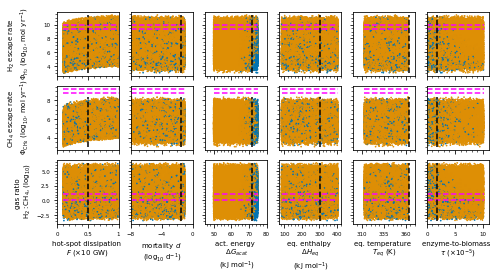

In [18]:
colors  = np.array(palette)[np.array(hab)]
keys1 = list(hist_param.keys())
keys2 = ['H2ab','CH4ab','R1ab']
rasterize_scatter = True
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        ymin = np.min(np.log10(hist_outcome[keys2[i]]))
        ymax = np.max(np.log10(hist_outcome[keys2[i]]))
        
        xmin = np.min(hist_param[keys1[j]])
        xmax = np.max(hist_param[keys1[j]])
        
        axes[i,j].plot([xmin,xmax],[logobservations[translate[keys2[i]]]]*2,'--',color='magenta')
        axes[i,j].plot([param_default[keys1[j]]]*2,[ymin,ymax],'--k')
        
        axes[i,j].scatter(hist_param[keys1[j]],np.log10(hist_outcome[keys2[i]]),s=0.5,c=colors,rasterized=rasterize_scatter)
        
        format_ticks(keys1[j],axes[i,j])
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]])
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]])
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.15)
fig.align_labels(axes)
#plt.savefig('figures/sensitivity_un.svg',dpi=400,bbox_inches='tight')
plt.show()

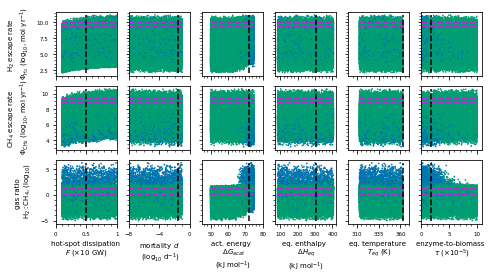

In [19]:
colors2  = np.array([palette[0],palette[2]])[np.array(hab)]
keys1 = list(hist_param.keys())
keys2 = ['H2bi','CH4bi','R1bi']
rasterize_scatter = True
fig,axes = plt.subplots(ncols=len(keys1),nrows=len(keys2),figsize=(7,4))
for i in range(len(keys2)):
    for j in range(len(keys1)):
        ymin = np.min(np.log10(hist_outcome[keys2[i]]))
        ymax = np.max(np.log10(hist_outcome[keys2[i]]))
        
        xmin = np.min(hist_param[keys1[j]])
        xmax = np.max(hist_param[keys1[j]])
        
        axes[i,j].plot([xmin,xmax],[logobservations[translate[keys2[i]]]]*2,'--',color='magenta')
        axes[i,j].plot([param_default[keys1[j]]]*2,[ymin,ymax],'--k')
        
        axes[i,j].scatter(hist_param[keys1[j]],np.log10(hist_outcome[keys2[i]]),s=0.5,c=colors2,rasterized=rasterize_scatter)
        
        format_ticks(keys1[j],axes[i,j])
        
        if j > 0:
            axes[i,j].set_yticklabels([])
        if i < len(keys2)-1:
            axes[i,j].set_xticklabels([])
        if j == 0:
            axes[i,j].set_ylabel(labels[keys2[i]])
        if i == len(keys2)-1:
            axes[i,j].set_xlabel(labels[keys1[j]])
            
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        axes[i,j].yaxis.set_minor_locator(AutoMinorLocator())
            
            
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.15)
fig.align_labels(axes)
#plt.savefig('figures/sensitivity_in.svg',dpi=400,bbox_inches='tight')
plt.show()

In [39]:
def plot_PH(var,ax,ymin=0.5,ymax=1,bins=20):
    Nu, X = np.histogram(hist_param[var][~hab_bool],bins=bins)
    Nh, X2= np.histogram(hist_param[var][hab_bool],bins=bins)
    ax.plot(X[1:],Nh/(Nh+Nu)-np.sum(hab_bool)/len(hab_bool),'.',markersize=3)
    ax.plot([param_default[var],param_default[var]],[ymin,ymax],'--k',linewidth=0.75)

In [21]:
hist_outcome

,H2ab,CH4ab,R1ab,H2bi,CH4bi,R1bi
0,1.245028e+05,1.974766e+05,0.630469,1.034799e+05,2.027323e+05,0.510426
1,1.129381e+05,3.602616e+04,3.134891,7.593759e+04,4.527630e+04,1.677204
2,1.385225e+05,1.693273e+04,8.180759,3.388519e+04,4.309206e+04,0.786344
3,5.923730e+07,2.446937e+05,242.087499,4.168681e+07,4.632316e+06,8.999128
4,6.809477e+04,1.282430e+07,0.005310,2.209660e+04,1.283580e+07,0.001721
...,...,...,...,...,...,...
49995,1.488006e+09,6.675963e+04,22289.005615,1.488006e+09,6.675963e+04,22289.005615
49996,5.168694e+04,8.957777e+05,0.057701,1.965367e+04,9.037861e+05,0.021746
49997,1.389539e+05,5.075812e+06,0.027376,7.114633e+04,5.092764e+06,0.013970
49998,1.824951e+05,1.369321e+05,1.332742,6.472085e+04,1.663757e+05,0.389004


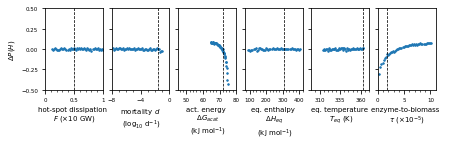

In [34]:
fig,axes = plt.subplots(ncols=len(hist_param.keys()),nrows=1,figsize=(7,1.5))
for i,var in enumerate(list(hist_param.keys())):
    plot_PH(var,axes[i],ymin=-0.5,ymax=0.5,bins=50)
    #axes[i].set_yticks([0,0.25,0.5,0.75,1])
    #axes[i].set_ylim(0,1)
    axes[i].set_yticks([-0.5,-0.25,0,0.25,0.5])
    axes[i].set_ylim(-0.5,0.5)
    if i == 0:
        axes[i].set_ylabel(r'$\Delta P(H)$')
    else:
        axes[i].set_yticklabels([])
    axes[i].set_xlabel(labels[var])
    format_ticks(var,axes[i])
    
    axes[i].xaxis.set_minor_locator(AutoMinorLocator())
    
plt.subplots_adjust(wspace=0.15, hspace=0.1)
fig.align_labels(axes)
#plt.savefig('figures/sensitivity_ph.svg',dpi=400,bbox_inches='tight')

In [41]:
hist_outcome.columns = ['H2_ab','CH4_ab','R1_ab','H2','CH4','R1']

In [40]:
def R1fun(out,I):
    if I:
        return(out['H2']/out['CH4'])
    else:
        return(out['H2_ab']/out['CH4_ab'])

def R2fun(out,I):
    if I:
        return(out['H2']/out['CO2'])
    else:
        return(out['H2_ab']/out['CO2_ab'])

def Ffun(out,var,I):
    #timec = 60*60*24*365
    if I:
        return(out[var])
    else:
        return(out[var+'_ab'])
    
def modelfun(I,H):
    if I:
        return('inhabited')
    elif H:
        return('habitable')
    else:
        return('uninhabitable')

def tablegen(Ntrain,simulations,PIH):
    Ntest  = len(simulations) - Ntrain
    keys = ['R1','FH2','FCH4']
    sim_hab = simulations['H2_ab'] != simulations['H2']
    reftable_data = {}
    reftable_ref  = []

    testtable_data = {}
    testtable_ref  = []

    
    for key in keys:
        reftable_data[key] = []
        testtable_data[key] = []
    for i in range(Ntrain):
        out = simulations.loc[i]
        I = False
        H = False
        if sim_hab[i]:
            H = True
            if np.random.rand()<PIH:
                I = True
        reftable_data['FH2'].append(Ffun(out,'H2',I))   
        reftable_data['FCH4'].append(Ffun(out,'CH4',I))
        reftable_data['R1'].append(R1fun(out,I))
        reftable_ref.append(modelfun(I,H))
        
    for i in range(Ntest):
        out = simulations.loc[Ntrain+i]
        I = False
        H = False
        if sim_hab[Ntrain+i]:
            H = True
            if np.random.rand()<PIH:
                I = True
        testtable_data['FH2'].append(Ffun(out,'H2',I))   
        testtable_data['FCH4'].append(Ffun(out,'CH4',I))
        testtable_data['R1'].append(R1fun(out,I))
        testtable_ref.append(modelfun(I,H))
        
    for key in keys:
        reftable_data[key] = np.array(reftable_data[key])
        testtable_data[key] = np.array(testtable_data[key])
    reftable_ref = np.array(reftable_ref)
    testtable_ref = np.array(testtable_ref)
    return(reftable_data,reftable_ref,testtable_data,testtable_ref)

In [42]:
reftable_data,reftable_ref,testtable_data,testtable_ref = tablegen(Ntrain = 40000,simulations=hist_outcome,PIH=0.5)
training_df = pd.DataFrame(data=reftable_data)
test_df     = pd.DataFrame(data=testtable_data)

In [43]:
rfcl = RandomForestClassifier(random_state=0,n_estimators=500,criterion='gini',max_depth=20,
                              max_features=3,warm_start=False,min_samples_leaf=10,min_samples_split=100,
                              bootstrap=True,max_leaf_nodes=None,oob_score=True)

In [44]:
rfcl.fit(training_df, reftable_ref)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [45]:
rfcl.predict(observations)

array(['inhabited', 'inhabited'], dtype='<U13')

In [46]:
crossvalid = rfcl.predict(test_df)

In [47]:
crossvalid

array(['habitable', 'habitable', 'habitable', ..., 'habitable',
       'inhabited', 'inhabited'], dtype='<U13')

In [48]:
probs = rfcl.predict_proba(observations)
mprob = np.mean(probs,axis=0)

In [49]:
rfcl.classes_

array(['habitable', 'inhabited', 'uninhabitable'], dtype='<U13')

In [50]:
total_table = np.log10(pd.DataFrame(data=reftable_data))
total_table['models'] = reftable_ref
translate = {'uninhabitable':0,'habitable':1,'inhabited':2}
total_table['model'] = np.array([translate[total_table['models'].loc[i]] for i in range(len(total_table))])

In [51]:
labelsDict = {'FH2':'$\Phi_{\mathregular{H_2}}$','FCH4':'$\Phi_{\mathregular{CH_4}}$','R1':'$\mathregular{H_2}:\mathregular{CH_4}$'}

In [37]:
## DO NOT RUN IF DESIRED DATA IS ALREADY PRESENT

K = 10
probs = np.linspace(0.05,0.95,K)
bootstrap = {'confusion':[],'PIH':[],'PI':[],'score':[],'prediction':[],'probabilities':[]}
for k in range(K):
    reftable_data,reftable_ref,testtable_data,testtable_ref = tablegen(Ntrain = 40000,simulations=hist_outcome,PIH=probs[k])
    training_df = pd.DataFrame(data=reftable_data)
    test_df = pd.DataFrame(data=testtable_data)
    rfcl = RandomForestClassifier(random_state=0,n_estimators=500,criterion='gini',max_depth=20,
                                  max_features=3,warm_start=False,min_samples_leaf=10,min_samples_split=100,
                                  bootstrap=True,max_leaf_nodes=None,oob_score=True)
    rfcl.fit(training_df, reftable_ref)
    crossvalid = rfcl.predict(test_df)
    matrix = metrics.confusion_matrix(testtable_ref,crossvalid)
    confusion     = np.round(matrix/np.repeat(np.sum(matrix,axis=1),3).reshape(3,3),2)
    score         = rfcl.score(test_df,testtable_ref)
    prediction    = rfcl.predict(observations)
    probabilities = rfcl.predict_proba(observations)
    
    bootstrap['confusion'].append(confusion)
    bootstrap['score'].append(score)
    bootstrap['prediction'].append(prediction)
    bootstrap['probabilities'].append(probabilities)
    bootstrap['PIH'].append(probs[k])
    bootstrap['PI'].append(np.sum(reftable_ref=='inhabited')/len(reftable_ref))  

In [73]:
# Uncomment to save new data
#np.save("data/sensitivity/bootstrap_sensi_corr.npy",bootstrap)

In [52]:
bootstrap = np.load("data/sensitivity/bootstrap_sensi_corr.npy",allow_pickle=True).item()

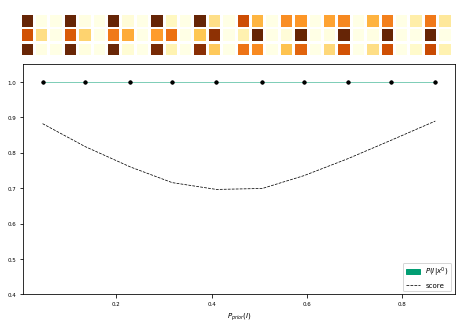

In [75]:
fig  = plt.figure(figsize=(6,4))
ax   = plt.axes([0.1,0,1,0.8])
MinP = np.min(np.array(bootstrap['probabilities'])[:,:,1],axis=1)
MaxP = np.max(np.array(bootstrap['probabilities'])[:,:,1],axis=1)

ax.plot(bootstrap['PI'],MinP,'k.')
ax.plot(bootstrap['PI'],MaxP,'k.')
ax.plot(bootstrap['PI'],bootstrap['score'],'--k',linewidth=0.75)
ax.fill_between(bootstrap['PI'],MaxP,MinP,color=palette[2],alpha=0.5)

ax.set_ylim(0.4,1.05)
#ax.plot(bootstrap['PI'],bootstrap['PI'],'--b')
handles = [mpatches.Patch(color=palette[2])]
handles.append(mlines.Line2D([], [], color='k',linestyle='--', linewidth=0.75))
ax.legend(handles=handles,labels=[r'$P(I|x^0)$','score'],loc='lower right')
ax.set_xlabel(r'$P_{prior}(I)$')
ticks=[]
width    = (1/len(bootstrap['confusion']))*2
Xcoords  = np.linspace(0.11,1.01,len(bootstrap['confusion'])) - width/3
for i in range(len(bootstrap['confusion'])):
    m = bootstrap['confusion'][i]
    yticks = ticks
    if i > 0:
        yticks = []
    ax2 = plt.axes([Xcoords[i],0.8,width,width])
    sns.heatmap(m,ax=ax2,annot=False,square=True,cmap='YlOrBr',
                linecolor='white',linewidths=2,cbar=False,annot_kws={'fontsize':6},
                xticklabels=ticks,yticklabels=yticks)
    bottom, top = ax2.get_ylim()
    ax2.set_ylim(bottom + 0.5, top - 0.5)
#plt.tight_layout()
#plt.savefig('figures/bootstrap_sensi.png',dpi=400,bbox_inches = 'tight')

In [53]:
inh_L = np.array(homestats.NLikelihood(total_table[total_table['model']==2],logobservations))
hab_L = np.array(homestats.NLikelihood(total_table[total_table['model']==1],logobservations))
uni_L = np.array(homestats.NLikelihood(total_table[total_table['model']==0],logobservations))

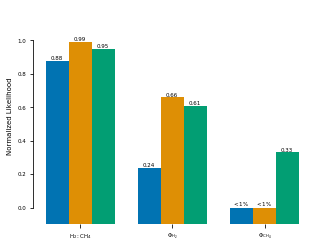

In [54]:
fig,ax =plt.subplots(figsize=(5,4))
Xticks = [labelsDict[k] for k in logobservations.keys()]
X = np.array([1,2,3])
width=0.25
bottom = -0.1
Urect = ax.bar(X-width,uni_L-bottom,width=width,color=palette[0],bottom=bottom)
Hrect = ax.bar(X,hab_L-bottom,width=width,color=palette[1],bottom=bottom)
Irect = ax.bar(X+width,inh_L-bottom,width=width,color=palette[2],bottom=bottom)
cplt.autolabel(Urect,ax,bottom=bottom)
cplt.autolabel(Hrect,ax,bottom=bottom)
cplt.autolabel(Irect,ax,bottom=bottom)
ax.set_xticks([1,2,3])
ax.set_xticklabels(Xticks)
ax.set_ylim(-0.1,1.2)
sns.despine(trim=True,bottom=True)
ax.set_ylabel('Normalized Likelihood')
#plt.savefig('figures/summary_likelihoods_sensi.png',dpi=400)
plt.show()

In [55]:
inhabited_data = total_table[total_table['model']==2][['R1','FH2','FCH4']]
homestats.get_Nli_range(inhabited_data,'FCH4',logobservations)

{'var': 'FCH4',
 'NL': 0.33167226922013504,
 'maxL': 6.592043753994006,
 'width': 0.2385606273598313,
 'obs': array([8.7998366 , 9.27695786]),
 'kernel': <scipy.stats.kde.gaussian_kde at 0x12b7159d0>}

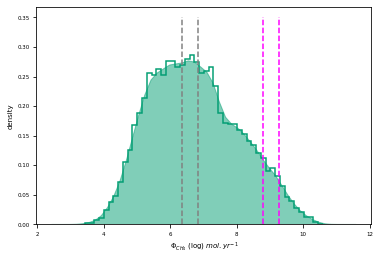

In [56]:
fig, ax = plt.subplots(figsize=(6,4))
cplt.plot_Likelihood(ax,inhabited_data,'FCH4',logobservations,
                    topval=0.35,histtype='step',density=True,bins=50,color=palette[2],linewidth=1.5)
ax.set_xlabel(r'$\Phi_{CH_4}$ (log) $mol.yr^{-1}$')
ax.set_ylabel('density')

plt.show()

In [57]:
labelsDict =  {'FH2' :'$\mathregular{H_2} $ escape rate \n $\Phi_{\mathregular{H_2} }$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCO2':'$\mathregular{CO_2}$ escape rate \n $\Phi_{\mathregular{CO_2}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'FCH4':'$\mathregular{CH_4}$ escape rate \n $\Phi_{\mathregular{CH_4}}$ ($\log_{10}$, $\mathregular{mol}~\mathregular{yr}^{-1}$)',
           'R1':'gas ratio \n $\mathregular{H_2}:\mathregular{CH_4}$, ($\log_{10}$)',
           'R2':r'$R_2$',
           'H2f':'HF $\mathregular{H_2}$ \n $[\mathregular{H_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2f':'HF $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4f':'HF $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_f$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'H2o' :'Ocean $\mathregular{H_2}$ \n $[\mathregular{H_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CO2o':'Ocean $\mathregular{CO_2}$ \n $[\mathregular{CO_2}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'CH4o':'Ocean $\mathregular{CH_4}$ \n $[\mathregular{CH_4}]_o$ \n ($\log_{10} \mathregular{mol}~\mathregular{kg}^{-1}$)',
           'Tf':'HF temperature \n $T_f$ (K)'}

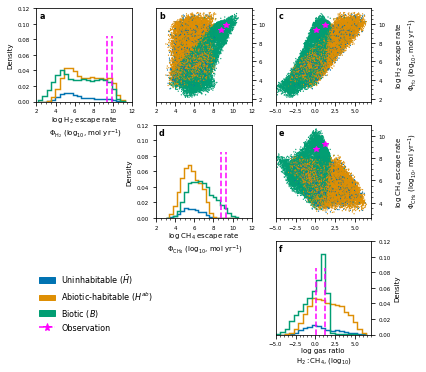

In [59]:
fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(6,6),constrained_layout=False)
gs = fig.add_gridspec(3, 3)

variables = ['FH2','FCH4','R1']
barlabels = np.array([r'$H^{ab}$',r'$B$',r'$\bar{H}$'])
palette = sns.color_palette('colorblind')
colors=[palette[total_table['model'].iloc[k]] for k in range(len(total_table))]

for i in range(3):
    for j in range(3):
        var = variables[i]
        var2 = variables[j]
        if var2 == 'R1':
            axes[i,j].set_xlim(-5,7)
        else:
            axes[i,j].set_xlim(2,12)
        if i==j:
            #cplt.kdemodelsplot(total_table,var=var,ax=axes[i,j],colors=palette)
            cplt.DistriPlot(ax=axes[i,j],data=total_table,var=var,Nbins=20,alpha=1,histtype='step',linewidth=1.45,palette=palette)
            axes[i,j].set_xlabel('log '+labelsDict[var],labelpad=1)
            #axes[i,j].set_ylabel('density')
            axes[i,j].plot([logobservations[var]]*2,[0,0.085],linestyle='--',color='magenta')
            axes[i,j].set_ylim(0,0.12) 
        elif i < j:
            axes[i,j].scatter(total_table[var2],total_table[var],c=colors,marker='d',s=0.1,rasterized=True)
            axes[i,j].plot(logobservations[var2],logobservations[var],marker='*',linestyle='',color='magenta')   
        axes[i,j].xaxis.set_minor_locator(AutoMinorLocator())
        
axes[2,0].axis('off')
axes[2,1].axis('off')
axes[1,0].axis('off')

axes[0,0].set_ylabel('Density')
axes[0,1].yaxis.tick_right()
axes[0,2].yaxis.tick_right()
axes[0,2].yaxis.set_label_position("right")
axes[0,2].set_ylabel('log '+labelsDict[variables[0]])
axes[1,1].set_ylabel('Density')
axes[1,2].yaxis.tick_right()
axes[1,2].yaxis.set_label_position("right")
axes[1,2].set_ylabel('log '+labelsDict[variables[1]])

axes[2,2].yaxis.tick_right()
axes[2,2].yaxis.set_label_position("right")
axes[2,2].set_ylabel('Density')



cols  = [0,1,2]*2+ [0,2]
xlabc = [0.135,0.41,0.69]*2+[0.13,0.69]
rows  = np.repeat([0,1,2],[3,3,2])
ylabc = np.repeat([0.855,0.58,0.32,0.31],[3,3,1,1])

labels = ['{0}'.format(letter) for letter in ['a','b','c','','d','e','','f']]

ax_boot = fig.add_subplot(gs[2,:2])
ax_boot.axis('off')


for i,j,z in [(0,0,0),(0,1,1),(0,2,2),(1,1,4),(1,2,5),(2,1,6),(2,2,7)]:
    axes[i,j].text(0.03,0.89,labels[z],transform=axes[i,j].transAxes,fontsize=8,weight='bold')
    
axes[0,1].yaxis.set_minor_locator(AutoMinorLocator())
axes[0,2].yaxis.set_minor_locator(AutoMinorLocator())
axes[1,2].yaxis.set_minor_locator(AutoMinorLocator())



uninh_patch = mpatches.Patch(color=palette[0], label=r'Uninhabitable ($\bar{H}$)')
habit_patch = mpatches.Patch(color=palette[1], label=r'Abiotic-habitable ($H^{ab}$)')
inhab_patch = mpatches.Patch(color=palette[2], label=r'Biotic ($B$)')
datap_line  = mlines.Line2D([], [], color='magenta', marker='*', linestyle='--', markersize=8, label='Observation')

axes[2,0].legend(handles = [uninh_patch, habit_patch, inhab_patch, datap_line],
                 fontsize=8,loc='lower left', borderaxespad=-0.1, frameon=False)

fig.align_labels(axes[:,2])

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig('figures/distributions_sensi.png',dpi=400,bbox_inches = 'tight')
plt.show()